# Baseline Model

This script applies a linear regression model the data driven feature set, given a baseline preformance for comparison.

In [19]:
import numpy as np
import pandas as pd
import datetime
import os
import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [20]:
# set variables from config file
config_path = os.path.abspath('..')

with open(config_path + '/config-example.json', 'r') as f:
    config = json.load(f)

processing_path = config['DEFAULT']['processing_path']
epc_train_clean_fname = config['DEFAULT']['epc_train_clean_fname']
epc_test_clean_fname = config['DEFAULT']['epc_test_clean_fname']
epc_train_dd_fname = config['DEFAULT']['epc_train_dd_fname']
epc_test_dd_fname = config['DEFAULT']['epc_test_dd_fname']
epc_fname_suffix = config['DEFAULT']['epc_fname_suffix']

In [21]:
epc_train = pd.read_csv(os.path.join(processing_path,epc_train_dd_fname) + epc_fname_suffix,header = 0,delimiter = ',')
epc_test = pd.read_csv(os.path.join(processing_path,epc_test_dd_fname) + epc_fname_suffix,header = 0,delimiter = ',')

In [22]:
epc_train.drop(['inspection_year'],axis=1,inplace=True)
# epc_test.drop(['TOTAL_FLOOR_AREA'],axis=1,inplace=True)

In [23]:
epc_train.head()

,CURRENT_ENERGY_EFFICIENCY,TOTAL_FLOOR_AREA,built_form,energy_tariff,floor_description,glazed_type,hotwater_description,lighting_description,mainheat_controls,property_type,roof_description,transaction_type,walls_description,window_description,extension,floor_height,habitable_rooms,open_fireplaces
0,69,129.0,End-Terrace,I dont know,I dont know,Double glazed,Coal boiler,No low energy lighting,Room thermostat,Few storey building,I dont know,Assessment,I dont know,full double glazing,0,2.3-2.4,6+,0
1,61,66.0,Mid-Terrace,I dont know,I dont know,Double glazed,Coal boiler,I dont know,Room thermostat,Few storey building,I dont know,Assessment,I dont know,full double glazing,0,NaN,4,0
2,29,290.0,End-Terrace,I dont know,I dont know,Double glazed,Coal boiler,I dont know,Prgrammer: room thermostat,Few storey building,I dont know,Assessment,I dont know,Double glazed,1,2.7+,6+,2+
3,55,130.0,End-Terrace,I dont know,I dont know,Double glazed,Coal boiler,no low energy lighting,Room thermostat,Few storey building,I dont know,New dwelling,I dont know,full double glazing,1,NaN,6+,0
4,77,99.0,Mid-Terrace,Dual,Concrete uninsulated floor pre 1990,Single glazed,Coal boiler,Low energy lighting,Prgrammer: room thermostat,Few storey building,I dont know,Assessment,I dont know,full double glazing,0,2.3-2.4,5,0


In [24]:
epc_test.head()

,CURRENT_ENERGY_EFFICIENCY,TOTAL_FLOOR_AREA,built_form,energy_tariff,floor_description,glazed_type,hotwater_description,lighting_description,mainheat_controls,property_type,roof_description,transaction_type,walls_description,window_description,extension,floor_height,habitable_rooms,open_fireplaces
0,71,73.00,End-Terrace,I dont know,I dont know,Double glazed,Coal boiler,I dont know,Room thermostat,Multiple storey building,I dont know,Private rental,I dont know,full double glazing,0,NaN,3,0
1,65,53.00,Mid-Terrace,I dont know,Timber un-insulated floor pre 1990,Single glazed,Coal boiler,low energy lighting 20% of fixed outlets,Room thermostat,Few storey building,I dont know,Assessment,I dont know,full double glazing,0,NaN,3,0
2,81,122.00,Other,Single,Insulated Timber 1990 above,NaN,Coal boiler,Low energy lighting,Room thermostat,Multiple storey building,I dont know,I dont know,I dont know,Double glazed from 2020,NaN,NaN,NaN,0
3,57,78.87,Mid-Terrace,I dont know,Timber un-insulated floor pre 1990,Double glazed,Coal boiler,low energy lighting 10% of fixed outlets,Room thermostat,Few storey building,I dont know,Private rental,I dont know,Double glazed,2+,2.3-2.4,5,0
4,64,81.00,Mid-Terrace,I dont know,I dont know,Double glazed,Coal boiler,I dont know,Prgrammer: room thermostat,Few storey building,I dont know,New dwelling,I dont know,full double glazing,0,NaN,5,0


### one hot encode categorical values

In [25]:
epc_train.columns

Index(['CURRENT_ENERGY_EFFICIENCY', 'TOTAL_FLOOR_AREA', 'built_form',
       'energy_tariff', 'floor_description', 'glazed_type',
       'hotwater_description', 'lighting_description', 'mainheat_controls',
       'property_type', 'roof_description', 'transaction_type',
       'walls_description', 'window_description', 'extension', 'floor_height',
       'habitable_rooms', 'open_fireplaces'],
      dtype='object')

In [26]:
# for col in ['MAINS_GAS_FLAG','HEAT_LOSS_CORRIDOR','built_form','energy_tariff','floor_description','floor_level',
#             'glazed_type','hotwater_description','lighting_description','mainheat_controls','property_type',
#             'roof_description','transaction_type','walls_description','window_description','locality','extension',
#             'floor_height','habitable_rooms','open_fireplaces']:
#     print(col)
#     for_dummy = epc_train.pop(col)
#     epc_train = pd.concat([epc_train, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [27]:
# for col in ['MAINS_GAS_FLAG','HEAT_LOSS_CORRIDOR','built_form','energy_tariff','floor_description','floor_level',
#             'glazed_type','hotwater_description','lighting_description','mainheat_controls','property_type',
#             'roof_description','transaction_type','walls_description','window_description','locality','extension',
#             'floor_height','habitable_rooms','open_fireplaces']:
#     print(col)
#     for_dummy = epc_test.pop(col)
#     epc_test = pd.concat([epc_test, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [28]:
def process_data_for_modelling(training_data,test_data):
    
    ''' 
    Prepares the data for modelling by one hot encoding the categorical features, converting discrete values into
    strings and dropping BUILDING_REFERENCE_NUMBER
    Parameters
      training_data: a dataframe of training data with columns called LODGEMENT_DATE, BUILDING_REFERENCE_NUMBER
      test_data: a dataframe of test data with columns called LODGEMENT_DATE, BUILDING_REFERENCE_NUMBER
    Returns two dataframes 
    '''
    
    training_data['mode'] = 'train'
    test_data['mode'] = 'test'
    epc = pd.concat([training_data, test_data])
    epc = epc.reset_index(drop = True)
    
    # try:
    #     epc.drop(['LODGEMENT_DATE'],axis=1,inplace=True)
    # except:
    #     pass
    
    try:
        epc['extension'] = epc['extension'].astype('str')
        epc['habitable_rooms'] = epc['habitable_rooms'].astype('str')
    except:
        pass
    
    for col in epc.dtypes[epc.dtypes == 'object'].index:
        if col not in ['mode']:
            print(col)
            for_dummy = epc.pop(col)
            epc = pd.concat([epc, pd.get_dummies(for_dummy, prefix=col)], axis=1)
        
    # features_to_drop = ['BUILDING_REFERENCE_NUMBER']
    # epc.drop(features_to_drop,axis=1,inplace=True)
    
    #Split back into train and test
    training_data = epc[epc['mode']=='train']
    test_data = epc[epc['mode']=='test']
    test_data = test_data.reset_index(drop=True)
    inputs_train = training_data.drop('mode',axis=1)
    inputs_test = test_data.drop('mode',axis=1)
    
    return inputs_train, inputs_test

In [29]:
inputs_train, inputs_test = process_data_for_modelling(epc_train, epc_test)

built_form
energy_tariff
floor_description
glazed_type
hotwater_description
lighting_description
mainheat_controls
property_type
roof_description
transaction_type
walls_description
window_description
extension
floor_height
habitable_rooms
open_fireplaces


In [30]:
inputs_train.head()

,CURRENT_ENERGY_EFFICIENCY,TOTAL_FLOOR_AREA,built_form_Detached,built_form_End-Terrace,built_form_Mid-Terrace,built_form_Other,built_form_Semi-Detached,energy_tariff_Dual,energy_tariff_I dont know,energy_tariff_Off-Peak,...,habitable_rooms_1,habitable_rooms_2,habitable_rooms_3,habitable_rooms_4,habitable_rooms_5,habitable_rooms_6+,habitable_rooms_nan,open_fireplaces_0,open_fireplaces_1,open_fireplaces_2+
0,69,129.0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,61,66.0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
2,29,290.0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
3,55,130.0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
4,77,99.0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0


In [31]:
inputs_test.head()

,CURRENT_ENERGY_EFFICIENCY,TOTAL_FLOOR_AREA,built_form_Detached,built_form_End-Terrace,built_form_Mid-Terrace,built_form_Other,built_form_Semi-Detached,energy_tariff_Dual,energy_tariff_I dont know,energy_tariff_Off-Peak,...,habitable_rooms_1,habitable_rooms_2,habitable_rooms_3,habitable_rooms_4,habitable_rooms_5,habitable_rooms_6+,habitable_rooms_nan,open_fireplaces_0,open_fireplaces_1,open_fireplaces_2+
0,71,73.00,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,65,53.00,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
2,81,122.00,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,57,78.87,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
4,64,81.00,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0


In [32]:
# inputs_train, inputs_test = process_data_for_modelling(epc_train, epc_test)

In [33]:
#Extract the target and features
target_train = inputs_train['CURRENT_ENERGY_EFFICIENCY']
inputs_train = inputs_train.drop('CURRENT_ENERGY_EFFICIENCY',axis=1)
target_test = inputs_test['CURRENT_ENERGY_EFFICIENCY']
inputs_test = inputs_test.drop('CURRENT_ENERGY_EFFICIENCY',axis=1)

In [34]:
inputs_train.to_csv('training_data.csv',index = False)
# inputs_test.to_csv('testing_data.csv')

### scale numeric values 

In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [36]:
# def scale_numeric(df,col):
    
#     ''' 
#     Fits a scaler called scaler to the specified column
#     Parameters
#       df: a dataframe
#       col: numeric variable to scale
#     Returns a dataframe
#     '''
    
#     null_index = df[col].isnull()
#     df.loc[~null_index, [col]] = scaler.fit_transform(df.loc[~null_index, [col]])
    
#     return df

In [37]:
# inputs_train = scale_numeric(inputs_train,'TOTAL_FLOOR_AREA')
# inputs_test = scale_numeric(inputs_test,'TOTAL_FLOOR_AREA')
# try:
#     inputs_train = scale_numeric(inputs_train,'floor_height')
#     inputs_test = scale_numeric(inputs_test,'floor_height')
# except:
#     pass
# try:
#     inputs_train = scale_numeric(inputs_train,'habitable_rooms')
#     inputs_test = scale_numeric(inputs_test,'habitable_rooms')
# except:
#     pass

### fill missing values

In [38]:
numeric_cols = inputs_train.dtypes[inputs_train.dtypes == 'float'].index

In [39]:
inputs_train[numeric_cols].isnull().sum().sort_values(ascending = False) / inputs_train.shape[0]

TOTAL_FLOOR_AREA    0.0
dtype: float64

In [40]:
inputs_test.head()

,TOTAL_FLOOR_AREA,built_form_Detached,built_form_End-Terrace,built_form_Mid-Terrace,built_form_Other,built_form_Semi-Detached,energy_tariff_Dual,energy_tariff_I dont know,energy_tariff_Off-Peak,energy_tariff_Single,...,habitable_rooms_1,habitable_rooms_2,habitable_rooms_3,habitable_rooms_4,habitable_rooms_5,habitable_rooms_6+,habitable_rooms_nan,open_fireplaces_0,open_fireplaces_1,open_fireplaces_2+
0,73.00,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
1,53.00,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2,122.00,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
3,78.87,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
4,81.00,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0


In [41]:
# inputs_train['floor_height'] = inputs_train['floor_height'].fillna(inputs_train['floor_height'].mean())
# inputs_train['habitable_rooms'] = inputs_train['habitable_rooms'].fillna(inputs_train['habitable_rooms'].mean())
# inputs_test['floor_height'] = inputs_test['floor_height'].fillna(inputs_test['floor_height'].mean())
# inputs_test['habitable_rooms'] = inputs_test['habitable_rooms'].fillna(inputs_test['habitable_rooms'].mean())

In [42]:
# inputs_train = inputs_train.drop('HEAT_LOSS_CORRIDOR',axis=1)
# inputs_test = inputs_test.drop('HEAT_LOSS_CORRIDOR',axis=1)

In [43]:
# epc_train[['TOTAL_FLOOR_AREA']].isnull().sum().sort_values(ascending = False) / epc_train.shape[0]

### Create input dataframes

In [44]:
inputs_train.head()

,TOTAL_FLOOR_AREA,built_form_Detached,built_form_End-Terrace,built_form_Mid-Terrace,built_form_Other,built_form_Semi-Detached,energy_tariff_Dual,energy_tariff_I dont know,energy_tariff_Off-Peak,energy_tariff_Single,...,habitable_rooms_1,habitable_rooms_2,habitable_rooms_3,habitable_rooms_4,habitable_rooms_5,habitable_rooms_6+,habitable_rooms_nan,open_fireplaces_0,open_fireplaces_1,open_fireplaces_2+
0,129.0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
1,66.0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
2,290.0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
3,130.0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
4,99.0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0


### Train the model

In [45]:
i_train = inputs_train.values
t_train = target_train.values.ravel()
i_test = inputs_test.values
t_test = target_test.values.ravel()

In [46]:
i_train

array([[129. ,   0. ,   1. , ...,   1. ,   0. ,   0. ],
       [ 66. ,   0. ,   0. , ...,   1. ,   0. ,   0. ],
       [290. ,   0. ,   1. , ...,   0. ,   0. ,   1. ],
       ...,
       [ 52. ,   1. ,   0. , ...,   1. ,   0. ,   0. ],
       [123.2,   0. ,   1. , ...,   0. ,   1. ,   0. ],
       [ 38. ,   0. ,   0. , ...,   1. ,   0. ,   0. ]])

In [47]:
#Initailise
reg = xgb.XGBRegressor(seed = 1234)
#train
reg.fit(i_train,t_train)

In [48]:
# #Initailise
# reg = xgb.XGBRegressor(n_estimators=250, learning_rate=0.2, max_depth=5)
# #train
# reg.fit(i_train,t_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [49]:
# #View the coefficients
# print('Coefficients: \n', reg.coef_)

# #View the intercept
# print(reg.intercept_)

In [50]:
#Get performance on training data
predict_train = reg.predict(inputs_train)
train_r_squared = r2_score(target_train,predict_train)
train_mse = mean_squared_error(target_train,predict_train)
print('Variance score: %.4f' % train_r_squared)
print("Mean squared error: %.4f" % train_mse)

Variance score: 0.6356
Mean squared error: 77.1564


In [51]:
#Get performance on test data
predict_test = reg.predict(inputs_test)
test_r_squared = r2_score(target_test,predict_test)
test_mse = mean_squared_error(target_test,predict_test)
print('Variance score: %.4f' % test_r_squared)
print("Mean squared error: %.4f" % test_mse)

Variance score: 0.6314
Mean squared error: 78.1145


In [52]:
feature_importance = reg.feature_importances_
feature_importance = pd.DataFrame(feature_importance,columns = ['feature_importance'])
feature_names = inputs_train.columns.values
feature_names = pd.DataFrame(feature_names,columns = ['feature_name'])
feature_importance = pd.merge(feature_names,
                                feature_importance,
                                left_index = True,
                                right_index = True,
                                how = 'inner')
feature_importance.sort_values('feature_importance',
                                ascending = False,
                                inplace = True)

print(feature_importance)

                                          feature_name  feature_importance
86                                       extension_nan            0.364697
58                   mainheat_controls_Room thermostat            0.070275
75              window_description_full double glazing            0.062206
45                              mainheat_controls_None            0.050309
100                                  open_fireplaces_0            0.048859
..                                                 ...                 ...
47                   mainheat_controls_Prgrammer: TRVs            0.000000
76   window_description_full double glazingdouble g...            0.000000
77   window_description_multiple glazing throughout...            0.000000
80   window_description_partial multiple glazingdou...            0.000000
25                    hotwater_description_Coal boiler            0.000000

[103 rows x 2 columns]


### Tune the model

In [ ]:
learning_rate_set = [0.1,0.2,0.3,0.4] #Learning rate
n_estimators_set = [150,200,250]  #Number of trees
max_depth_set = [3,4,5] #Depth of tree

In [ ]:
# sample of datasets to speed up training
inputs_train_sample = inputs_train.iloc[:50000,:]
target_train_sample = target_train.iloc[:50000]

In [ ]:
def tune_model(inputs_train, target_train, inputs_test, target_test, model=['adaboost','GBT','forest','xgboost'],
              learning_rate_set, n_estimators_set, max_depth_set):
    
    ''' 
    Fits one of four models, Adaboost, Gradient Boosted Trees, Random Forest or XGBoost, tunes using the 
    specified parameter sets. Note this takes a long time to run and the compuation time will increase with
    the number of parameters
    Parameters
      inputs_train: a dataframe of training data
      target_train: a series of the target for training
      input__test: a dataframe of test data must have the same columns as inputs_train
      target_test: a series of the target for testing
      model: ['adaboost','GBT','forest','xgboost']
      learning_rate_set: set of learning rates to test
      n_estimators_set: set of number of trees to test
      max_depth_set: set of max tree depths to test
    '''
    
    if model == 'adaboost':
        reg = AdaBoostRegressor(random_state = 1234)
    elif model == 'GBT':
        reg = GradientBoostingRegressor(random_state = 1234)
    elif model == 'forest':
        reg = RandomForestRegressor(n_jobs = -1, random_state = 1234)
    else:
        i_train = inputs_train.values
        t_train = target_train.values.ravel()
        i_test = inputs_test.values
        t_test = target_test.values.ravel()
        reg = xgb.XGBRegressor(seed = 1234)
        
    parameters = {'learning_rate':learning_rate_set, 'n_estimators':n_estimators_set, 'max_depth':max_depth_set}
    reg_tuned = GridSearchCV(reg, parameters)
    reg_tuned.fit(inputs_train, target_train)
        
    if model in ['adaboost','GBT','forest']:
        reg_tuned.fit(inputs_train, target_train)    
    else:
        reg_tuned.fit(i_train, t_train)
    
    print(reg_tuned.best_params_)
    print(reg_tuned.best_score_)

In [ ]:
train_model(inputs_train_sample, target_train_sample, inputs_test, target_test, 'xgboost')

## Results by band

predict_test_series = pd.Series(predict_test)
test_scored = pd.DataFrame(target_test)
test_scored = test_scored.reset_index(drop=True)
test_scored['predicted_score'] = predict_test_series

In [53]:
predict_test_series = pd.Series(predict_test)
test_scored = pd.DataFrame(target_test)
test_scored = test_scored.reset_index(drop=True)
test_scored['predicted_score'] = predict_test_series

In [54]:
band_bins = [-1,0,20,38,54,68,80,91,100]
band_labels = ['I','G','F','E','D','C','B','A']
test_scored['predicted_band'] = pd.cut(test_scored['predicted_score'],bins = band_bins, labels = band_labels)
test_scored['actual_band'] = pd.cut(test_scored['CURRENT_ENERGY_EFFICIENCY'],bins = band_bins, labels = band_labels)

In [55]:
# average accuracy per band
(test_scored['actual_band'] == test_scored['predicted_band']).sum()/len(test_scored)

0.6014038092755674

In [56]:
# accuracy for each band
test_scored['correct_band'] = test_scored['actual_band'] == test_scored['predicted_band']
test_scored.groupby('actual_band')['correct_band'].sum()/test_scored.groupby('actual_band')['correct_band'].count()

actual_band
I    0.000000
G    0.220241
F    0.184681
E    0.400295
D    0.760889
C    0.525638
B    0.743819
A    0.000000
Name: correct_band, dtype: float64

In [57]:
# manipulating data for heatmap
for_heatmap = test_scored[['actual_band','predicted_band']]
for_dummy = for_heatmap.pop('actual_band')
for_heatmap = pd.concat([for_heatmap, pd.get_dummies(for_dummy)], axis=1)
for_heatmap_summed = for_heatmap.groupby('predicted_band')['A','B','C','D','E','F','G'].sum()

C:\Users\KingRemy\AppData\Local\Temp\ipykernel_10160\3882052621.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  for_heatmap_summed = for_heatmap.groupby('predicted_band')['A','B','C','D','E','F','G'].sum()


In [58]:
def get_pct(x):
    return (x/(x.sum()))*100

In [59]:
for_heatmap_summed = for_heatmap_summed.apply(get_pct,axis = 0)

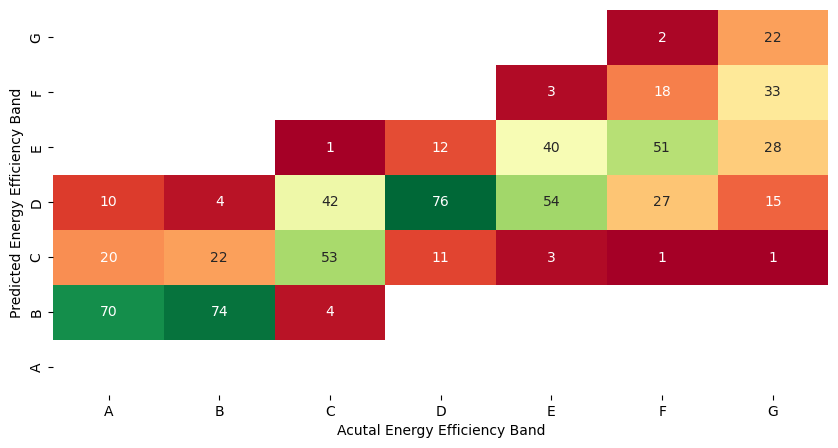

In [60]:
heatmap_test = round(for_heatmap_summed,0)
heatmap_test = heatmap_test.replace(0,np.nan)
heatmap_test = heatmap_test.loc[['G','F','E','D','C','B','A'],:]

f = plt.figure(figsize=(10,5))
sns.heatmap(heatmap_test, cmap='RdYlGn',annot=True,cbar=False)
plt.xlabel('Acutal Energy Efficiency Band')
plt.ylabel('Predicted Energy Efficiency Band')
plt.show()

In [61]:
reg.save_model("EnergyEfficiencyTool2.json")

In [62]:
inputs_train.to_csv('training_data.csv')
# inputs_test.to_csv('testing_data.csv')

In [63]:
inputs_train.columns.values.tolist()

['TOTAL_FLOOR_AREA',
 'built_form_Detached',
 'built_form_End-Terrace',
 'built_form_Mid-Terrace',
 'built_form_Other',
 'built_form_Semi-Detached',
 'energy_tariff_Dual',
 'energy_tariff_I dont know',
 'energy_tariff_Off-Peak',
 'energy_tariff_Single',
 'energy_tariff_Standard Tariff',
 'floor_description_Concrete uninsulated floor pre 1990',
 'floor_description_I dont know',
 'floor_description_Insulated Timber 1990 above',
 'floor_description_Insulated concrete 1990 above',
 'floor_description_Timber un-insulated floor pre 1990',
 'floor_description_average thermal transmittance 1.9 w/m²k',
 'floor_description_average thermal transmittance 2.5 w/m²k',
 'floor_description_average thermal transmittance 3.1 w/m²k',
 'floor_description_suspended',
 'floor_description_trawsyriannedd thermol cyfartalog 0.15 w/m²k',
 'glazed_type_Double glazed',
 'glazed_type_Double glazed from 2020',
 'glazed_type_I dont know',
 'glazed_type_Single glazed',
 'hotwater_description_Coal boiler',
 'lighting_